In [1]:
%matplotlib inline
import skcuda.linalg    # Version tested @ https://github.com/bmenn/scikit-cuda/tree/cusolver-eigen
                        # commit 2d4bbfe68b9f644c98286e567fe2d0c7b4eef1fd
import scipy.linalg
import numpy.linalg
import numpy as np
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import time

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
skcuda.linalg.init()

## System Info
tl;dr
i7-4790k, 4x8GB DDR3 1600MHz, NVIDIA GTX 980Ti

```
$ sudo lshw -C cpu -C display -C memory
  *-firmware
       description: BIOS
       vendor: American Megatrends Inc.
       physical id: 0
       version: V4.9
       date: 05/28/2015
       size: 64KiB
       capacity: 8128KiB
       capabilities: pci upgrade shadowing cdboot bootselect socketedrom edd int13floppy1200 int13floppy720 int13floppy2880 int5printscreen int9keyboard int14serial int17printer acpi usb biosbootspecification uefi
  *-cpu
       description: CPU
       product: Intel(R) Core(TM) i7-4790K CPU @ 4.00GHz
       vendor: Intel Corp.
       physical id: 3d
       bus info: cpu@0
       version: Intel(R) Core(TM) i7-4790K CPU @ 4.00GHz
       slot: SOCKET 0
       size: 4350MHz
       capacity: 4400MHz
       width: 64 bits
       clock: 100MHz
       capabilities: x86-64 fpu fpu_exception wp vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpimmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc aperfmperf eagerfpu pni pclmulqdq dtes64 monitor ds_cpl vmx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm tpr_shadow vnmi flexpriority ept vpid fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt dtherm ida arat pln pts cpufreq
       configuration: cores=4 enabledcores=4 threads=8
     *-cache:0
          description: L1 cache
          physical id: 3e
          slot: CPU Internal L1
          size: 256KiB
          capacity: 256KiB
          capabilities: synchronous internal write-back
          configuration: level=1
     *-cache:1
          description: L2 cache
          physical id: 3f
          slot: CPU Internal L2
          size: 1MiB
          capacity: 1MiB
          capabilities: synchronous internal write-back unified
          configuration: level=2
     *-cache:2
          description: L3 cache
          physical id: 40
          slot: CPU Internal L3
          size: 8MiB
          capacity: 8MiB
          capabilities: synchronous internal write-back unified
          configuration: level=3
  *-memory
       description: System Memory
       physical id: 42
       slot: System board or motherboard
       size: 32GiB
     *-bank:0
          description: DIMM DDR3 Synchronous 1600 MHz (0.6 ns)
          product: BLS8G3D1609DS1S00.
          vendor: Conexant (Rockwell)
          physical id: 0
          serial: 32A06BFF
          slot: ChannelA-DIMM0
          size: 8GiB
          width: 64 bits
          clock: 1600MHz (0.6ns)
     *-bank:1
          description: DIMM DDR3 Synchronous 1600 MHz (0.6 ns)
          product: CMZ16GX3M2A1600C10
          vendor: AMI
          physical id: 1
          serial: 00000000
          slot: ChannelA-DIMM1
          size: 8GiB
          width: 64 bits
          clock: 1600MHz (0.6ns)
     *-bank:2
          description: DIMM DDR3 Synchronous 1600 MHz (0.6 ns)
          product: BLS8G3D1609DS1S00.
          vendor: Conexant (Rockwell)
          physical id: 2
          serial: 32A06BF1
          slot: ChannelB-DIMM0
          size: 8GiB
          width: 64 bits
          clock: 1600MHz (0.6ns)
     *-bank:3
          description: DIMM DDR3 Synchronous 1600 MHz (0.6 ns)
          product: CMZ16GX3M2A1600C10
          vendor: AMI
          physical id: 3
          serial: 00000000
          slot: ChannelB-DIMM1
          size: 8GiB
          width: 64 bits
          clock: 1600MHz (0.6ns)
  *-display
       description: VGA compatible controller
       product: GM200 [GeForce GTX 980 Ti]
       vendor: NVIDIA Corporation
       physical id: 0
       bus info: pci@0000:01:00.0
       version: a1
       width: 64 bits
       clock: 33MHz
       capabilities: pm msi pciexpress vga_controller bus_master cap_list rom
       configuration: driver=nvidia latency=0
       resources: irq:31 memory:f6000000-f6ffffff memory:e0000000-efffffff memory:f0000000-f1ffffff ioport:e000(size=128) memory:c0000-dffff
```

In [2]:
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

In [3]:
funcs = {
    'numpy': numpy.linalg.eigvalsh,
    'scipy': scipy.linalg.eigvalsh,
    'scikit-cuda': skcuda.linalg.eig,
}
data = []
print 'Testing ',
for p in range(1, 14):
    # Do 5 samples at each size
    n = 2**p
    print 'n=%d' % n,
    for i in range(5):
        A = np.random.rand(n, n)
        A = symmetrize(A)
        for name, f in funcs.iteritems():
            if name == 'scikit-cuda':
                A_gpu = gpuarray.to_gpu(A)
                start = time.time()
                f(A_gpu, jobvl='N', jobvr='N', lib='cusolver')
                stop = time.time()
            else:
                start = time.time()
                f(A)
                stop = time.time()
            data.append({
                'library': name,
                'n': n,
                'iter': i,
                'duration': stop - start
            })

Testing  n=2 n=4 n=8 n=16 n=32 n=64 n=128 n=256 n=512 n=1024 n=2048 n=4096 n=8192


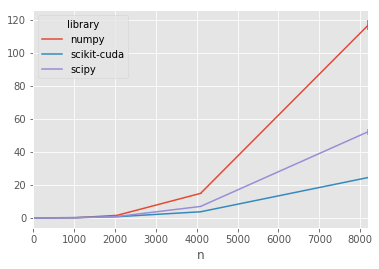

In [4]:
df = pd.DataFrame(data)
means = df.groupby(['n', 'library'])['duration'].mean().unstack(1)
errors = df.groupby(['n', 'library'])['duration'].std().unstack(1)

means.plot.line(yerr=errors)